In [ ]:
## TO RUN WHILE USING GOOGLE-COLAB
# !pip install numba --q
# !pip install qiskit ipywidgets --q 
# !wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qmcmc_codes/qbm_utils_2.py

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
import numba
from numba import jit, typeof, types
import time 
from qbm_utils_2 import *

In [ ]:
# @jitclass([('J', typeof(J)), ('h', typeof(h)), ('beta', typeof(beta)), ('num_spins', types.float64)])
# class tryal:
#     """A class to build the Ising Hamiltonian from data"""
#     # J: np.array
#     # h: np.array
#     # beta: float
#     def __init__(self, J: np.array, h: np.array, beta: float = 1.0) -> None:
#         self.J = J
#         self.h = h
#         self.beta = beta
#         self.num_spins = len(h)
    
#     @property
#     def get_J(self):
#         return self.J

#     @property
#     def get_h(self):
#         return self.h

    
#     def get_energy(self, state: Union[str, np.array]) -> float:
#         """'state' should be a bipolar state if it is an array"""

#         if isinstance(state, str):
#             state = np.array([-1 if elem == "0" else 1 for elem in state])
#             # state = np.array( [int(list(state)[i]) for i in range(len(state))])
#             energy = 0.5 * np.dot(state.transpose(), self.J.dot(state)) + np.dot(
#                 self.h.transpose(), state
#             )
#             return energy
#         else:
#             return 0.5 * np.dot(state.transpose(), self.J.dot(state)) + np.dot(
#                 self.h.transpose(), state
#             )
#     # @jit(nopython= True)
#     def get_partition_sum(self, beta: float = 1.0):  ## is computationally expensive

#         all_configs = np.array(list(itertools.product([1, 0], repeat=self.num_spins)))
#         return sum([self.get_boltzmann_prob(configbeta=beta) for config in all_configs])

#     # @jit(nopython= True)
#     def get_boltzmann_prob(
#         self, state: Union[str, np.array], beta: float = 1.0, normalised=False
#     ) -> float:

#         if normalised:
#             return np.exp(-1 * beta * self.get_energy(state)) / self.get_partition_sum(
#                 beta
#             )

#         else:
#             return np.exp(-1 * beta * self.get_energy(state))


### Define the model

In [2]:
# define the model
np.random.seed(1)# should always be in the same cell!  
n_spins = 10 * 2

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

# defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.uniform(low= -1, high= 1, size = (n_spins,n_spins)), decimals=2)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
# print("J before:"); print(J)
J= J - np.diag(np.diag(J))

# J=np.array([[0,1,0.5,-1],[1,0,0.3,0.5],[0.5,0.3,0,1],[-1,0.5,1,0]])
# print("J after:", J)

# defining h
h = np.round(np.random.randn(n_spins), decimals=2)#np.random.uniform(low= -1, high = 1, size= (n_spins))
# h=np.array([0.5]*n_spins)
# print("h is:", h);

# instantiate the model
model = IsingEnergyFunction(J, h)
# print(model.get_energy('0100'))
alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )
# print("alpha: ", alpha);

### Get the true distribution

In [3]:
# @jit(nopython = True)
def true_boltzman_distn(n_spins:int, temp:int, model, wanna_plot=False):

    states_nbit=states(num_spins=n_spins)# arranged in ascending order in magnitude
    # Actual_probability distribution
    transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state, beta=1./temp) ) for state in tqdm(states_nbit) ] )
    rqd_sum=np.sum(np.array(list(transits_bltz.values())))
    prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
    ### unsorted prob distribution
    bpd=dict(zip(states_nbit, prob_vals ))### dict of distn, arranged in ascending order of keys
    ### Prob distribution, sorted in descending order of prob values
    boltz_prob_distn_sorted_desc=value_sorted_dict( bpd, reverse=True )
    # plot distribution
    if wanna_plot:
        plt.figure(2)
    plot_bargraph_desc_order(boltz_prob_distn_sorted_desc, label="analytical",plot_first_few=20); plt.legend()
    
    return boltz_prob_distn_sorted_desc, bpd

In [44]:
states_nbit=states(num_spins=n_spins)# arranged in ascending order in magnitude
# Actual_probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state, beta=1./temp) ) for state in tqdm(states_nbit) ] )
rqd_sum=np.sum(np.array(list(transits_bltz.values())))
prob_vals=list(np.array(list(transits_bltz.values()))*(1./rqd_sum))
### unsorted prob distribution
bpd=dict(zip(states_nbit, prob_vals ))


100%|██████████| 1048576/1048576 [02:02<00:00, 8584.55it/s] 


100%|██████████| 1048576/1048576 [01:27<00:00, 11957.38it/s]


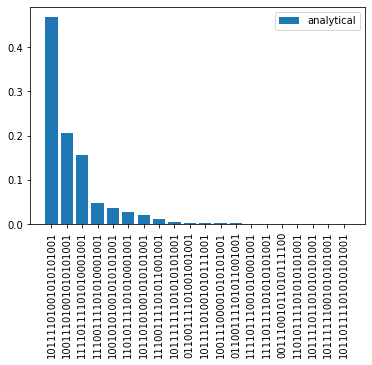

In [4]:
states_nbit=states(num_spins=n_spins)
temp=0.4
boltz_prob_distn,bpd=true_boltzman_distn(n_spins, temp=temp, model=model, wanna_plot=True)#dict sorted in vals,dict sorted in keys
# plot_histogram([bpd], legend=["analytical"])

In [6]:
entrpy = np.sum([ -1 * pi * np.log2(pi) for pi in tqdm(boltz_prob_distn.values()) ]) 
var_entrpy = np.sum([ 1 * pi * (np.log2(1/pi))**2 for pi in tqdm(boltz_prob_distn.values()) ])
entrpy, np.sqrt(var_entrpy)

100%|██████████| 1048576/1048576 [00:19<00:00, 53619.83it/s]


(2.3816229657586296, 3.0037438788127804)

In [17]:
entropt_f = lambda x : -1 * x * np.log2(x) 

In [20]:
t0 = time.process_time()
print( np.sum([ -1 * pi * np.log2(pi) for pi in tqdm(boltz_prob_distn.values()) ]) )
t1 = time.process_time()
a = np.array(list(boltz_prob_distn.values()))
print(np.sum( entropt_f(a) ))
t2 = time.process_time()


t1-t0, t2-t1

100%|██████████| 1048576/1048576 [00:09<00:00, 114063.53it/s]


2.3816229657586296
2.3816229657586296


(9.373958196999979, 0.6778787700000066)

In [8]:
def truncate_distribution(prob_dist: dict):
    """ Truncate a given probability distribution based n typicality """
    
    lmd_entrpy  = lambda x : -1 * x * np.log2(x) 
    lmd_entrpy_2 = lambda x : x * (np.log2(x))**2
    prob_vals = np.array(list(prob_dist.values()))
    
    entropy = np.sum(lmd_entrpy(prob_vals))
    entropy_var = np.sqrt(np.sum(lmd_entrpy_2(prob_vals)))


    for s, prob in value_sorted_dict(prob_dist).items() :
        
        

    

    

In [47]:
list()

ValueError: too many values to unpack (expected 2)

In [10]:
# mag_all_states=dict_magnetization_of_all_states(list_all_possible_states=states_nbit)
# actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=mag_all_states)
# print("actual_avg_mag: ",actual_avg_mag)

### Function to run different number of mcmc chains for a particular problem instance

In [11]:
# SOME UPDATED FUNCTIONS
def uncommon_els_2_lists(list_1,list_2):
  return list(set(list_1).symmetric_difference(set(list_2)))

def merge_2_dict(dict1, dict2):
    return({**dict1,**dict2})

def sort_dict_by_keys(dict_in:dict):
  from collections import OrderedDict
  return dict(OrderedDict(sorted(dict_in.items())))

# some changes in clasical mcmc
def classical_mcmc(
    N_hops: int,
    num_spins: int,
    initial_state: str,
    num_elems: int,
    model,
    return_last_n_states=500,
    return_both=False,
    temp=1,
):
    """
    Args:
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model:
    return_last_n_states: (int) Number of states in the end of the M.Chain you want to consider for prob distn (default value is last 500)
    return_both (default=False): If set to True, in addition to dict_count_return_lst_n_states, also returns 2 lists:
                                "list_after_transition: list of states s' obtained after transition step s->s' " and
                                "list_after_acceptance_step: list of states accepted after the accepance step".
    Returns:
    Last 'dict_count_return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it!
    """
    states_obt = []
    # current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    current_state = initial_state
    print("starting with: ", current_state)
    states_obt.append(current_state)

    ## initialiiise observables
    # observable_dict = dict([ (elem, []) for elem in observables ])
    list_after_transition = []
    list_after_acceptance_step = []

    for i in tqdm(range(0, N_hops)):
        # get sprime
        s_prime = classical_transition(num_spins)
        list_after_transition.append(s_prime)
        # accept/reject s_prime
        energy_s = model.get_energy(current_state)
        energy_sprime = model.get_energy(s_prime)
        next_state = classical_loop_accepting_state(
            current_state, s_prime, energy_s, energy_sprime, temp=temp
        )
        current_state = next_state
        list_after_acceptance_step.append(current_state)
        states_obt.append(current_state)
        # WE DON;T NEED TO DO THIS! # reinitiate
        # qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)

    # returns dictionary of occurences for last "return_last_n_states" states
    ### added by neel 22-11-22
    all_possible_states_nbit=states(num_spins=num_spins)
    states_sampled=states_obt[-return_last_n_states:]
    states_not_obtained=uncommon_els_2_lists(all_possible_states_nbit, states_sampled)
    val_states_not_obtained=[0]*len(states_not_obtained)
    dict_states_not_obtained=dict(zip(states_not_obtained, val_states_not_obtained ))
    ### added by neel 22-11-22
    dict_count_return_last_n_states = merge_2_dict(dict(Counter(states_obt[-return_last_n_states:])), dict_states_not_obtained)

    if return_both:
        to_return = (
            dict_count_return_last_n_states,
            list_after_transition,
            list_after_acceptance_step,
        )
    else:
        to_return = dict_count_return_last_n_states

    return to_return

# some changes i quantum mcmc.
def quantum_enhanced_mcmc(
    N_hops: int,
    num_spins: int,
    initial_state: str,
    num_elems: int,
    model: IsingEnergyFunction,
    alpha,
    return_last_n_states=500,
    return_both=False,
    temp=1,
):
    """
    version 0.2
    Args:
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model:
    alpha:
    return_last_n_states:
    return_both:
    temp:

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it!
    """
    states_obt = []
    print("starting with: ", initial_state)

    ## initialise quantum circuit to current_state
    qc_s = initialise_qc(n_spins=num_spins, bitstring=initial_state)
    current_state = initial_state
    states_obt.append(current_state)
    ## intialise observables
    list_after_transition = []
    list_after_acceptance_step = []

    for i in tqdm(range(0, N_hops)):
        # print("i: ", i)
        # get sprime
        s_prime = run_qc_quantum_step(
            qc_initialised_to_s=qc_s, model=model, alpha=alpha, n_spins=num_spins
        )
        list_after_transition.append(s_prime)
        # accept/reject s_prime
        energy_s = model.get_energy(current_state)
        energy_sprime = model.get_energy(s_prime)
        next_state = classical_loop_accepting_state(
            current_state, s_prime, energy_s, energy_sprime, temp=temp
        )
        current_state = next_state
        list_after_acceptance_step.append(current_state)
        states_obt.append(current_state)
        ## reinitiate
        qc_s = initialise_qc(n_spins=num_spins, bitstring=current_state)

    # dict_count_return_last_n_states = Counter(
    #     states[-return_last_n_states:]
    # )  # dictionary of occurences for last "return_last_n_states" states
    ### added by neel 22-11-22
    all_possible_states_nbit=states(num_spins=num_spins)
    states_sampled=states_obt[-return_last_n_states:]
    states_not_obtained=uncommon_els_2_lists(all_possible_states_nbit, states_sampled)
    val_states_not_obtained=[0]*len(states_not_obtained)
    dict_states_not_obtained=dict(zip(states_not_obtained, val_states_not_obtained ))
    ### added by neel 22-11-22
    dict_count_return_last_n_states = merge_2_dict(dict(Counter(states_obt[-return_last_n_states:])), dict_states_not_obtained)


    if return_both:
        to_return = (
            dict_count_return_last_n_states,
            list_after_transition,
            list_after_acceptance_step,
        )
    else:
        to_return = dict_count_return_last_n_states

    return to_return

In [12]:
def run_mcmc_different_chains(num_spins:int, 
N_hops:int,num_seperate_mcmc_chains:int ,model,temp:float, 
return_last_n_states:int,return_both=False, is_quantum_mcmc=False, alpha=None ):

    num_elems=2**(num_spins)
    dict_seperate_chains_states_distn_mcmc={}
    dict_seperate_chains_sprime_mcmc={}
    dict_seperate_chains_accepted_mcmc={}
    dict_seperate_chains_counts_based_on_hamming_dist={}# we can get rid of these things
    dict_seperate_chains_energy_diff_s_and_sprime={}# for plotting histogram
    poss_states=list(range(0,num_elems))
    print(f"Whether running quantum mcmc: {is_quantum_mcmc}")
    for chain_num in tqdm(range(0,num_seperate_mcmc_chains)):
        init_state=np.random.choice(poss_states)
        poss_states.remove(init_state)# to ensure that each mcmc chain starts with a different initial state
        initial_state=f'{init_state:0{num_spins}b}'#f'{np.random.randint(0,num_elems):0{num_spins}b}'
        if is_quantum_mcmc:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                alpha,return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)
        else:
            dict_states_mcmc, state_mcmc_after_trsn, state_mcmc_after_accept =classical_mcmc(N_hops, num_spins, 
                                                                                initial_state,
                                                                                num_elems,model, 
                                                                                return_last_n_states=return_last_n_states,
                                                                                return_both=True, temp=temp)                                                                        
        # sorting states in descending order of values(# occurences in mcmc chains)  for keys(states) 
        dict_states_mcmc_sorted_desc=value_sorted_dict(dict_states_mcmc, reverse=True)#dict_states_mcmc# this is where I might have to change things a little bit
        #storing in a dict
        dict_seperate_chains_states_distn_mcmc[chain_num]=dict_states_mcmc_sorted_desc
        dict_seperate_chains_sprime_mcmc[chain_num]=state_mcmc_after_trsn
        dict_seperate_chains_accepted_mcmc[chain_num]=state_mcmc_after_accept
        dict_seperate_chains_energy_diff_s_and_sprime[chain_num]=energy_difference_related_counts(num_spins, state_mcmc_after_trsn, state_mcmc_after_accept, model_in=model)
        dict_seperate_chains_counts_based_on_hamming_dist[chain_num]=hamming_dist_related_counts(num_spins, state_mcmc_after_trsn, state_mcmc_after_accept)

    return dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist


In [13]:
# 10 seperate chains of classical mcmc for the given problem instance
N_hops=1000;num_seperate_mcmc_chains=4; return_last_n_states=N_hops
# later get rid of energy difference and hamming distance dicts.
dict_seperate_chains_states_distn_mcmc, dict_seperate_chains_sprime_mcmc, dict_seperate_chains_accepted_mcmc, dict_seperate_chains_energy_diff_s_and_sprime,dict_seperate_chains_counts_based_on_hamming_dist=run_mcmc_different_chains(n_spins, 
N_hops, num_seperate_mcmc_chains,
model, temp=temp, return_last_n_states=return_last_n_states,
return_both=True )

Whether running quantum mcmc: False


  0%|          | 0/4 [00:00<?, ?it/s]

starting with:  00001100110101100001


 25%|██▌       | 1/4 [00:29<01:28, 29.37s/it]

starting with:  01000001100000110111


 50%|█████     | 2/4 [00:39<00:36, 18.08s/it]

starting with:  11111000010000100111


 75%|███████▌  | 3/4 [00:49<00:14, 14.44s/it]

starting with:  00000011110111111101


100%|██████████| 4/4 [00:58<00:00, 14.61s/it]


# TO DO:
get empirical distribution instead of count of occurence

In [72]:
# kl divergence
# calculate the kl divergence
from math import log2
from math import sqrt
from numpy import asarray
import time 


# @jit(nopython= True)
def kl_divergence(p:list, q:list):
    return np.sum( np.array( [p[i] * log2(p[i]/q[i]) for i in range(len(p)) if p[i]!=0 ] ))
    

# calculate the js divergence
def js_divergence(dict_p:dict, dict_q:dict):
  t0 = time.process_time()
  p=asarray(list(dict_p.values())); q=asarray(list(dict_q.values()))
  t1 = time.process_time()
  m = 0.5 * (p + q)
  #print("m is:");print(m)
  return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

def running_js_divergence(list_chain_state_accepted:list, actual_boltz_distn:dict):
  num_nhops=len(list_chain_state_accepted)
  list_js_after_each_step=[]
  possible_states=list(actual_boltz_distn.keys())
  for step_num in tqdm(range(1,num_nhops, int(num_nhops/10 ) )):
      print("step_num: ",step_num)
      t_i = time.process_time()
      #temp_distn_model=get_distn(list_chain_state_accepted[:step_num])
      ### added by me today:
      # 1. get list of unique elements in list_chain_state_accepted
      # 2. get list of allowed state not present in list_chain_state_accepted (list_states_not_present)
      # 3. create a temp_distn_model= 
      unique_els_list_of_accept_states=list(np.unique(list_chain_state_accepted[:step_num]))
      
      list_states_not_present=uncommon_els_2_lists(unique_els_list_of_accept_states,
                                                  possible_states)
      t1 = time.process_time()
      

      dict_states_not_obtained= dict(zip(list_states_not_present, [0]*len(list_states_not_present) ))
      temp_distn_model= merge_2_dict(get_distn(list_chain_state_accepted[:step_num]),dict_states_not_obtained)
      temp_distn_model= sort_dict_by_keys(temp_distn_model)#arranged in ascedning order of keys

      t2 = time.process_time()
      
      #Merge(get_distn(list_chain_state_accepted[:step_num]), dict(zip()))
      # print("temp_distribution:")
      # print(temp_distn_model)
      # print(f"len(temp_distn_model):{len(temp_distn_model)}")
      print('bpd :', len(actual_boltz_distn.keys()), '  mcmc-dist :', len(unique_els_list_of_accept_states))
      # print('diff :',  len(set(temp_distn_model.keys()).intersection(actual_boltz_distn)) )
      #js divergence
      js_temp=js_divergence(actual_boltz_distn,temp_distn_model)

      # print(js_temp)
      list_js_after_each_step.append(js_temp)

      t3 = time.process_time()
      print("t_1:", t1 - t_i) ##cflag
      print("t_2:", t2 - t1) ##cflag
      print("t_3:", t3 - t2) ##cflag

      #print(f"at step={step_num} of MCMC , KL Divergence: {js_temp}")
  return list_js_after_each_step

In [73]:
truncated_bpd = {}
for s, prob in boltz_prob_distn.items():
    if prob > 0.000001 : truncated_bpd[s] = prob
    else : break 


In [74]:
list_running_js=[]
for i in range(0,num_seperate_mcmc_chains):# need to make this fast! it running very slowly rn
  # print("i:",i)
  chain_accepted_state=dict_seperate_chains_accepted_mcmc[i]
  running_js=running_js_divergence(chain_accepted_state, bpd)
  list_running_js.append(running_js)
  plt.figure()
  plt.plot(np.sqrt(running_js))
  plt.xlabel("mcmc steps")
  plt.ylabel("J-S Distance")

step_num:  1
bpd : 1048576   mcmc-dist : 1


t_1: 1.458134685999994
t_2: 11.246085330000028
t_3: 5.1265201080000224
step_num:  101
bpd : 1048576   mcmc-dist : 2


t_1: 0.8929075569999441
t_2: 10.547859276000054
t_3: 5.382445367999935
step_num:  201
bpd : 1048576   mcmc-dist : 2


t_1: 0.9702128179999363
t_2: 10.702463350000016
t_3: 4.859177816000056
step_num:  301
bpd : 1048576   mcmc-dist : 2


t_1: 0.8932597210000495
t_2: 10.510797434000096
t_3: 4.93145583699993
step_num:  401
bpd : 1048576   mcmc-dist : 2


t_1: 0.8399460180000915
t_2: 11.252402302000064
t_3: 4.9924054619998515
step_num:  501
bpd : 1048576   mcmc-dist : 2


t_1: 0.9421357770002032
t_2: 11.456219293000004
t_3: 5.159789465999893
step_num:  601
bpd : 1048576   mcmc-dist : 3


t_1: 0.9893780350000725
t_2: 12.245017598000004
t_3: 5.428496016000054
step_num:  701
bpd : 1048576   mcmc-dist : 3


t_1: 0.8970088149999356
t_2: 10.603453195999919
t_3: 5.0657802739999624
step_num:  801
bpd : 1048576   mcmc-dist : 3


t_1: 0.8208844079999835
t_2: 11.188858979000088
t_3: 5.654068904999804
step_num:  901
bpd : 1048576   mcmc-dist : 3


100%|██████████| 10/10 [02:51<00:00, 17.16s/it]

t_1: 0.9434861279999041
t_2: 10.56449636100001
t_3: 5.072765621999906


step_num:  1
bpd : 1048576   mcmc-dist : 1


t_1: 0.9792871989998275
t_2: 10.8548387190001
t_3: 5.571382400999937
step_num:  101
bpd : 1048576   mcmc-dist : 3


t_1: 0.8709236709999004
t_2: 10.255971347000013
t_3: 5.0087077939999745
step_num:  201
bpd : 1048576   mcmc-dist : 3


t_1: 0.8515341449999596
t_2: 10.488812934999942
t_3: 5.504392183999926
step_num:  301
bpd : 1048576   mcmc-dist : 4


t_1: 1.0124808500002018
t_2: 10.883221661999869
t_3: 5.1797167510001145
step_num:  401
bpd : 1048576   mcmc-dist : 4


t_1: 0.8330095530000108
t_2: 10.46051783200005
t_3: 5.155131389999951
step_num:  501
bpd : 1048576   mcmc-dist : 4


t_1: 0.846635951999815
t_2: 10.69870281600015
t_3: 4.986288613999932
step_num:  601


In [ ]:
def plot_mean_running_avg(list_of_list:list, label:str):
  mean_running_val=np.mean(np.sqrt(list_of_list),axis=0)
  std=np.std(np.sqrt(list_of_list),axis=0)
  plt.fill_between(range(len(mean_running_val)), mean_running_val+std/2, mean_running_val-std/2, alpha=0.1)
  plt.plot(mean_running_val,"-",label=label, linewidth=2)

In [ ]:
plot_mean_running_avg(list_running_js,label="cl mcmc")
plt.xlabel("mcmc iter");plt.ylabel("JS Distance");plt.legend()

In [ ]:
### data for plotting running average magnetization (averaged over "num_seperate_mcmc_chains" number of mcmc chains):
first_few=N_hops# 

list_for_df_running_avg_seperate_mcmc = []
for m in range(0, num_seperate_mcmc_chains):
    list_for_df_running_avg_seperate_mcmc.append(running_avg_magnetization_as_list(dict_seperate_chains_accepted_mcmc[m][:first_few+1]))

In [ ]:
mean_magnetization = np.mean(list_for_df_running_avg_seperate_mcmc, axis=0) - actual_avg_mag
std_magnetization = np.std(list_for_df_running_avg_seperate_mcmc, axis=0)
plt.fill_between(range(len(mean_magnetization)), mean_magnetization+std_magnetization/2, mean_magnetization-std_magnetization/2, alpha=0.1)

plt.plot(mean_magnetization,":" ,label="Cl mcmc", linewidth=2)

plt.axhline(y=0,linestyle="-", color="k" ,label="Actual")
plt.legend()
# plt.ylim(0, 3)
plt.ylabel("Magnetization error")
plt.xlabel("MCMC steps")
plt.xscale("log")
# plt.yscale("log")
# plt.ylim(1e-2, 3)
plt.show()


In [ ]:
# pandas data_frame for prob distn obtained from different mcmc chains
def fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_mcmc):
    df=pd.DataFrame(dict_seperate_chains_states_mcmc)
    df=df.fillna(0)
    return df

def get_dict_mean_occurences(df_seperate_chains_mcmc_states_occurences):
    mean_occurences=df_seperate_chains_mcmc_states_occurences.mean(axis=1)
    #print("mean occurences:"); print(mean_occurences)
    #print(f"type(mean_occurences): {type(mean_occurences)}")
    dict_mean_occurences=mean_occurences.to_dict()# mean number of occurences; we took mean of data obtained for mcmc chains
    # plt.figure(1); mean_occurences.plot.bar()
    return dict_mean_occurences

def get_empirical_distn(dict_mean_occurences):
    sum_of_counts = sum(dict_mean_occurences.values())
    empirical_probs=list(np.array(list(dict_mean_occurences.values()))/sum_of_counts)
    ### Prob distribution, sorted in descending order of prob values
    dict_empirical_prob_distn=dict(zip(list(dict_mean_occurences.keys()), empirical_probs ))
    return dict_empirical_prob_distn




In [ ]:
### for classical mcmc
df_1=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc)
dict_mean_occurences=get_dict_mean_occurences(df_1)
dict_empirical_cl_prob_distn=get_empirical_distn(dict_mean_occurences)

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn],
                        list_labels=["analytical","classical-uniform MCMC"],
                        list_normalise=[False,False] ,plot_first_few=16,  
                        sort_desc=True,figsize=(10,7))

In [ ]:
np.sqrt(js_divergence(boltz_prob_distn,dict_empirical_cl_prob_distn))

### Quantum enhanced MCMC

In [ ]:
# 10 seperate chains of quantum mcmc for the given problem instance
N_hops_q=1000;num_seperate_mcmc_chains_q=4; return_last_n_states_q=N_hops_q
dict_seperate_chains_states_distn_mcmc_q, dict_seperate_chains_sprime_mcmc_q, dict_seperate_chains_accepted_mcmc_q, dict_seperate_chains_energy_diff_s_and_sprime_q,dict_seperate_chains_counts_based_on_hamming_dist_q=run_mcmc_different_chains(n_spins, 
N_hops_q, num_seperate_mcmc_chains_q,
model, temp=temp, return_last_n_states=return_last_n_states_q,
return_both=True, is_quantum_mcmc=True, alpha=alpha )

In [ ]:
list_running_js_q=[]
for i in range(0,num_seperate_mcmc_chains):
  print("i:",i)
  chain_accepted_state_q=dict_seperate_chains_accepted_mcmc_q[i]
  running_js_q=running_js_divergence(chain_accepted_state_q,bpd)
  list_running_js_q.append(running_js_q)
  plt.figure()
  plt.plot(np.sqrt(running_js_q))
  plt.xlabel("mcmc steps")
  plt.ylabel("J-S Distance")

In [ ]:
plot_mean_running_avg(list_running_js_q,label="q mcmc")
plot_mean_running_avg(list_running_js,label="cl mcmc")
plt.xlabel("mcmc iter");plt.ylabel("JS Distance");plt.legend()

In [ ]:
### data for plotting running average magnetization 5 cases seperately:
first_few=N_hops_q# 
list_for_df_running_avg_seperate_mcmc_q = []
for m in range(0, num_seperate_mcmc_chains_q):
    list_for_df_running_avg_seperate_mcmc_q.append(running_avg_magnetization_as_list(dict_seperate_chains_accepted_mcmc_q[m][:first_few+1]))


In [ ]:
mean_magnetization_q = np.mean(list_for_df_running_avg_seperate_mcmc_q, axis=0) - actual_avg_mag
std_magnetization_q = np.std(list_for_df_running_avg_seperate_mcmc_q, axis=0)

plt.figure(figsize=(10,7))

plt.fill_between(range(len(mean_magnetization)), mean_magnetization+std_magnetization/2, mean_magnetization-std_magnetization/2, alpha=0.1)
plt.fill_between(range(len(mean_magnetization_q)), mean_magnetization_q+std_magnetization_q/2, mean_magnetization_q-std_magnetization_q/2, alpha=0.1)

# magnetization_of_all_states=dict_magnetization_of_all_states(states_nbit)
# actual_avg_mag=avg(dict_probabilities=boltz_prob_distn, dict_observable_val_at_states=magnetization_of_all_states)

plt.plot(mean_magnetization,"-" ,label="classical mcmc")
plt.plot(mean_magnetization_q,"-" ,label="quant mcmc")
plt.axhline(y=0,linestyle="--", color="k" ,label="Actual")
plt.legend()
#plt.ylim(-1, 1)
plt.ylabel("Magnetization error")
plt.xlabel("MCMC steps")
plt.show()

In [ ]:
### for quantum mcmc
df_q=fn_get_dataframe_diff_mcmc_chains_same_problem_instance(dict_seperate_chains_states_distn_mcmc_q)
dict_mean_occurences_q=get_dict_mean_occurences(df_q)
dict_empirical_prob_distn_q=get_empirical_distn(dict_mean_occurences_q)

plt.figure(1)
plot_multiple_bargraphs(list_of_dicts=[boltz_prob_distn, dict_empirical_cl_prob_distn,dict_empirical_prob_distn_q],
                        list_labels=["analytical","Cl-MCMC","Quant MCMC"],
                        list_normalise=[False,False,False] ,plot_first_few=10,  
                        sort_desc=True,figsize=(10,7))

In [ ]:
print("JS distance quantum case:");
print(np.sqrt(js_divergence(dict_empirical_prob_distn_q,boltz_prob_distn)))
print("JS distance classical case:")
print(np.sqrt(js_divergence(dict_empirical_cl_prob_distn,boltz_prob_distn)))

In [ ]:
# def similarity_coefficient(target_prob_distn:dict, model_prob_distn:dict):
#   """ Returns: Bhattacharya coefficient BC(P,Q)= \sum_{i} sqrt(P(i)*Q(i))
#       Args: target_prob_distn: P
#             model_prob_distn: Q, approximates P
#   """
#   list_prob_model=list(target_prob_distn.values())
#   list_prob_data=list(model_prob_distn.values())
#   list_keys_model=list(model_prob_distn.keys())

#   sim_coeff=0
#   for i in range(0,len(list_keys_model)):
#       if(list_prob_data[i]== 0 or list_prob_model==0):
#           to_return+= 0
#       else:
#         sim_coeff+=np.sqrt(list_prob_data[i]*list_prob_model[i])
#   return sim_coeff

# def running_sim_coeff(list_chain_state_accepted:list,actual_boltz_distn:dict):
#   num_nhops=len(list_chain_state_accepted)
#   list_sim_coeff_after_each_step=[]
#   for step_num in range(1,num_nhops):
#     #print("step_num: ",step_num)
#     temp_distn_model=get_distn(list_chain_state_accepted[:step_num])
#     #print("temp_distribution:")
#     #print(temp_distn_model)
#     sim_coeff_temp=similarity_coefficient(actual_boltz_distn,temp_distn_model)
#     list_sim_coeff_after_each_step.append(sim_coeff_temp)
#     print(f"at step={step_num} of MCMC , bhatt.coeff: {sim_coeff_temp}")
#   return list_sim_coeff_after_each_step